# CXR Audit  
This notebook contains the code for automating the grading of chest X-ray reports using two complementary approaches.

Large Language Models (LLMs) have been increasingly employed in radiology for diverse tasks, notably semantic information extraction and the generation of structured radiology reports. Traditionally, radiology reports undergo manual classification post-interpretation into broad categories such as normal, abnormal, and critical, which guide subsequent clinical management. Building upon these capabilities, this study aims to investigate the application of LLMs for automated grading of chest X-ray reports into these clinically relevant categories. By leveraging LLMs in this capacity, we seek to streamline radiological workflow processes, alleviate the cognitive burden on radiologists, and enhance the consistency of follow-up recommendations. Although vision-language models (VLMs) and convolutional neural network (CNN)-based computer vision approaches show promise in the direct interpretation of imaging studies, current clinical practice predominantly relies on human-in-the-loop reporting to ensure diagnostic accuracy and safety. Our approach endeavors to preserve the advantages of human oversight while automating a critical step in the reporting pipeline—report categorization—whose failure may lead to significant clinical consequences.

## The Methods

The first method, a semi-LLM algorithmic method, extracts structured findings from reports, then assigns priorities accordingly.  
The second method leverages a LLM to directly grade reports. 

## Our Goal  
To grade CXRs by the following grading scheme  

>   
> Grading (R):
> 1 = normal without any findings
> 2 = normal variant or minor pathology, does not require follow up
> 3 = abnormal, non-urgent follow-up required
> 4 = abnormal, potentially important finding
> 5 = critical, urgent follow-up required
>   
(Note the revised grading from the prior version)
(Notably, this grading system is much less ambiguous, and similar to current or previous grading systems used by other institutions e.g. KTPH, Singhealth)

(From TTSH DDR Handbook)  
Grade 6 should be used for critical, life threatening findings, including:
- Pneumothorax
- Aortic dissection
- Mediastinal emphysema
- Pneumoperitoneum
- Portal venous air
- Dilated bowel loops
- Significant tube or line misplacement e.g. malpositioned NGT

Grade 6 should also be used unexpected, life-changing findings, including:
- New lesions that are suspicious for malignancy
- New fracture
- New large volume pleural effusions
- New aneurysm

In [ ]:
# Consider the following prompt
'''
You are well versed in medical terminology for Chest X Ray reports, and your task is to review the given report and grade the report on a scale of 1 to 6, to 1 decimal point.

You will do the above by

1. listing out findings
2. assigning if each findings requires any follow up and at which interval
3. give the grading by considering all findings

Enlarged heart size only needs follow up if other related changes.

Unfolded aorta, vascular calcifications, chronic bone findings, scarring changes do NOT need any follow up.
Benign findings also do NOT require follow up.
Patient rotation and suboptimal effort do NOT require follow up.

Pleural thickening and atelectasis can be followed up after months, unless otherwise qualified.

Potential infections and possible fluid overload or pulmonary congestion are always actionable within 1 week.
Any changes which have increased from before are actionable within 1 week.

Pneumoperitoneum, aortic dissection or pneumothorax of any size are critical emergencies! P1 remarks are also emergencies!

Grading:
1 = normal without any findings
2 = any findings which do not require follow up
3 = actionable from 2 months onwards
4 = actionable by 1 month
5 = actionable within 1 week
6 = immediate action required

Mainly use the highest grade of a finding, especially for grades 5 or 6.
You may use an average between grade (such as 2.5, 3.5 etc) for other grades.
'''

# Our task for this script
'''
First, we classify the list of reports into positive findings
- Pathological findings
    > Lung
    > Pleura
    > Heart
    > Mediastinum
    > MSK
    > Abdomen
- Tube and line findings (malpositioning)

Then whether the finding is new, better, worse or stable

Below is a sample of an X-ray report, enclosed in three backticks (```). Please generate a list of positive findings from the report, and whether the finding is new, better, worse or stable.
'''

'''
Notes:
- If the chronicity of a finding is not mentioned, follow the path of "new"
- If a finding is "probably" X, it should be considered as X
- Find any P1 and P2SMS findings
- Find either new or worsening findings - should be R5
- Better or stable findings should be downgraded by one grade? R3?
- Uncertain findings can be downgraded by one grade
- If the only finding is "heart size cannot be assessed", it should be R2
- If the only finding is suboptimal technique, it should be R2
- Unfolded aorta should be R2
    - Is this the only situation for R2?
- Any line present should be at least R4 (unless malpositioned)
    - NGT can be R4
    - Any other line should be at least R5 (because they're seen in critically ill pts)
    - Malpositioned lines are all R6 (P1)
'''

# Method 1: Semi-LLM, Semi-Algorithmic Approach  

This semi-algorithmic approach first uses an LLM to semantically extract structured data (a list of positive anatomical findings and any medical devices) from a chest X-ray report, based on predefined lists derived from the Padchest labels. The overall maximum priority for the report is computed as the highest of the priorities.

1. First we extract a list of findings from the report, and grade them according to:
    - Temporal: ['new', 'better', 'worse', 'stable', 'not mentioned']
        - If a finding is new, we upgrade its priority by 1
        - If a finding is stable/better, we downgrade its priority by 1
    - Uncertainty: ['certain', 'uncertain', 'not mentioned']
        - If a finding is uncertain (e.g. "possibly", "may represent", "could be", "cannot be excluded"), we downgrade its priority by 1
    - Misplaced tubes & lines automatically get P1.
2. Then we grade the findings/lines according to their respective priorities (e.g. pneumothorax is R6, consolidation is R5, scarring is R2).
    - Tubes and lines are mostly R5 as they are mostly seen in critically ill patients
    - The exception is chronic support lines like NGT and tracheostomy tube that are R3-4 as they can be reviewed one or more months later
3. We find the max priority of the report overall.
  
  
---
  
Prompt for semantic extraction of the findings:  

> ### Your Task
> Below is a sample of an X-ray report, enclosed in \<report\> tags. 
>   
> \<report\>  
> {sample_report}  
> \</report\>  
>   
> Please generate a list of positive findings from the report, and whether the finding is new, better, worse or stable.   
> Also, please specify if any medical devices (tubes & lines) are present in the report and their placement, whether it is satisfactory or malpositioned.  
> Medical devices should not be in "findings" but in "devices". If there is no medical device, please return an empty list for "devices_all" ([]).  
> Mastectomy, surgical clips and surgical plates should be considered as findings and not as medical devices.  
>   
> Please choose the finding from this list. \  
> Use only the term that best fits the finding. \  
> Do not return a finding that is not in this list. \  
> List all positive findings only. Negative findings should not be included.  
>   
> Here is the list of findings: {padchest_findings_str}  
>   
> Here is a list of medical devices (tubes & lines): {tubes_lines_findings_str}  
>   
> Here is a list of overarching diagnoses: {diagnoses_str}  
>   
> Here is a description of the parameters:  
> For the anatomical findings  
> - finding: Pathological finding mentioned in the report, using the list above. Do not return a finding that is not in this list. If you think the finding is not in this list, return the closest one from the list.  
> - location: Location of the finding, e.g. right lower zone  
> - system: System of the body where the finding is located -- Lung, Pleura, Heart, Mediastinum, MSK, Abdomen  
> - temporal: new, better, worse, stable or not mentioned  
> - uncertainty: certain, uncertain, not mentioned  
>   
> For the medical devices (tubes & lines)  
> - medical_device: Name of the tube/line, using the list above. Do not return a device that is not in this list.  
> - placement: Placement of the tube/line -- satisfactory, suboptimal (abnormal but no urgent action is required), malpositioned (urgent repositioning or removal is required) or not mentioned  
>   
> For the diagnoses  
> - diagnosis: Overarching diagnosis suggested in the report, using the list above. Do not return a diagnosis that is not in this list.  
>     - For example, if "...suggestive of infection" is mentioned, return "pneumonia" as the diagnosis.  
>     - For example, if "...may be related to infection" is mentioned, return "pneumonia" as the diagnosis.  
>     - For example, if "...malignancy cannot be excluded" is mentioned, return "malignancy" as the diagnosis.  
>     - For example, if "...P1 for..." is mentioned, return "P1" as the diagnosis.  
> - temporal: new, better, worse, stable or not mentioned  
>   
> ### Finer Points  
> If the heart size is not accurately assessed, this should NOT be considered as a finding.  
> If the only finding is that there is no consolidation or pleural effusion with no other findings, this should be considered as a normal report with no finding. \  
> Even if "no consolidation" or "no pleural effusion" is qualified, for example "no confluent consolidation", \  
> "no large pleural effusion" or "no frank pleural effusion" \  
> this should be considered as a normal report with no finding.  
> If a finding is "probably", "suggestive of", "likely" or any other similar phrase that indicates a low uncertainty, \  
> this should be considered as a finding with "certain" uncertainty.  
> If a finding is "possibly", "may represent", "could be", "cannot be excluded" \  
> or any other similar phrase that indicates a high uncertainty, this should be considered as a finding with "uncertain" uncertainty.  
> A rotated or suboptimally inspired film can be considered as "suboptimal study".  
> Findings written in pleural should be considered as singular (e.g. "pleural effusions" as "pleural effusion", "nodular opacities" as "nodular opacity", "granulomas" as "granuloma").  
> 
> If the report suggests the possibility of a diagnosis of pneumonia, infection, or suggests correlation with infective markers, this diagnosis should be raised.  
> If the report suggests the possibility of a diagnosis of tuberculosis, atypical infection or mycobacterial infection, this diagnosis should be raised.  
> If the report suggests the possibility of a tumour, malignancy, or neoplasm, this diagnosis should be raised.
>     - If a CT thorax was suggested for an opacity, the diagnosis is "malignancy".  
> If the reporting radiologist indicated at the end that the report is "P1", this diagnosis should be raised.  
>     - This can come in the format "P1 for X", or "Dr xx was informed at the time of reporting".  
>     
> If the report suggests that a diagnosis "cannot be excluded", it should be considered as a positive diagnosis.  
> If the report suggests that a diagnosis from the diagnoses list is "possible", it should be considered as a positive diagnosis.  
  

# Option 2: All-LLM Approach  
This approach just asks the LLM to grade the report directly, giving it some instructions.  
  
---  
  
Prompt used:  
  
> Below is a chest X-ray report, enclosed in \<report\> tags.  
> Please grade the report on a scale of 1 to 6, to 1 decimal point.  
> Return the highest grade of the findings in the report.  
>   
> Grading (R):  
> 1 = normal without any findings  
> 2 = normal variant or minor pathology, does not require follow up  
> 3 = abnormal, non-urgent follow-up required  
> 4 = abnormal, potentially important finding  
> 5 = critical, urgent follow-up required  
>   
> Grade 5 should be used for critical, life threatening findings, including:  
> - Pneumothorax  
> - Aortic dissection  
> - Mediastinal emphysema  
> - Pneumoperitoneum  
> - Portal venous air  
> - Dilated bowel loops  
> - Significant tube or line misplacement e.g. malpositioned NGT  
>   
> Grade 5 should also be used unexpected, life-changing findings, including:  
> - New lesions that are suspicious for malignancy  
> - New fracture  
> - New large volume pleural effusions  
> - New aneurysm  
>   
> Any finding that has significant clinical impact that is new or worsening should be graded as 4  
> (save for those to be graded as 2, as below).  
> If the chronicity of a finding is not mentioned, it should be considered as new.  
> If a finding is "probably" X, it should be considered as X.  
>   
> Enlarged heart size only needs follow up if other related changes.  
>   
> Unfolded aorta, vascular calcifications, chronic bone findings, lung scarring and an unfolded thoracic aorta do NOT need any follow up and should be graded as 2.  
> Benign findings also do NOT require follow up and should be graded as 2.  
> Patient rotation and suboptimal effort do NOT require follow up and should be graded as 2.  
> If there is suboptimal technique with no other finding, this should be graded as 2.  
>   
> Pleural thickening and atelectasis should be grade 3, unless otherwise qualified.  
>   
> Potential infection/consolidation and possible fluid overload or pulmonary congestion should be graded as 4.  
> Patchy opacities, airspace opacities and hazy opacities should be graded as 4 for new pneumonia/infection.  
> A small pleural effusion can be graded as 3, but significant ones (moderate/severe) should be graded as 4.  
> If the report suggests the possibility of a diagnosis of pneumonia, infection, or suggests correlation with infective markers, this should be graded as 4.  
> If the report suggests the possibility of a diagnosis of tuberculosis, atypical infection or mycobacterial infection, this should be graded as 4.  
>     - If the report suggests that tuberculosis is stable, this should be graded as 3.  
> If the report suggests the possibility of a tumour, malignancy, or neoplasm, this should be graded as 4.  
>     - If the report suggests that the tumour is stable, this should be graded as 3.  
> If the reporting radiologist indicated at the end that the report is "P1", this should be graded as 5.  
>     - This can come in the format "P1 for X", or "Dr xx was informed at the time of reporting".  
>   
> Any line present should be at least grade 3 (unless malpositioned, in which case it should be grade 6)  
>     - A nasogastric tube in a satisfactory position can be grade 3  
>     - Any other line should be at least grade 4 (because they're seen in critically ill pts)  
>     - Malpositioned lines are all grade 5.  
>   
> Please provide your answer in a valid JSON with the following format:  
> {  
>     "grade": float (1 to 5, to 1 decimal point)  
> }  
>   
> Please grade this CXR report:  
>   
> \<report\>  
> {cxr_report}  
> \</report\>


# Results Analysis

Now we can have a look at the results. 

In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

df_reports_overall = pd.read_csv('../data_audit/200_judged.csv')
# Remove rows with missing values in any of the three grading columns
df_clean = df_reports_overall.dropna(subset=['priority_manual', 'priority_algo', 'priority_llm'])

C:\Users\covie\AppData\Local\Temp\ipykernel_38504\1392657606.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Admission_Type'] = df_clean['Admission_Type'].replace({'I': 1, 'O': 0})


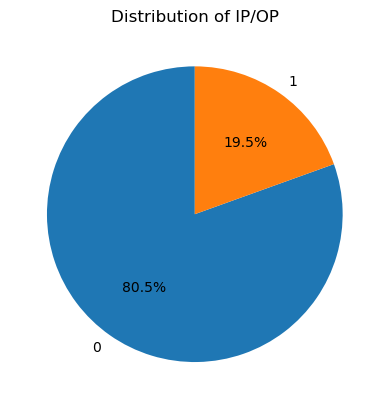

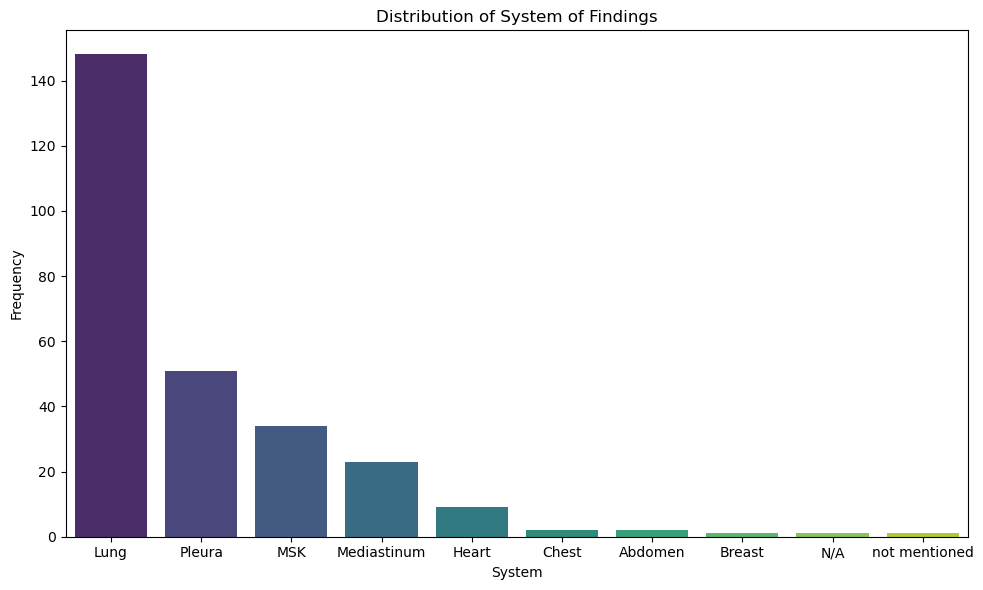

In [2]:
#####################################
### Plot the distribution of data ###
#####################################

# Plot the distribution of IP/OP
df_clean['Admission_Type'] = df_clean['Admission_Type'].replace({'I': 1, 'O': 0})
# Plot the distribution as a pie chart
df_clean['Admission_Type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of IP/OP')
plt.ylabel('')
plt.show()

# Plot the distribution of the system of findings as a bar graph
import ast
from collections import Counter

df_with_findings = pd.read_csv(r"C:\Users\covie\OneDrive\Documents\Work\Research\PRIME\data_audit\v1\100_findings_v2_classified.csv")

# Function to parse a string representation of a list of dictionaries
def parse_findings(findings_str):
    try:
        # Try literal_eval first
        return ast.literal_eval(findings_str)
    except Exception:
        try:
            # If that fails, try json.loads (after replacing single quotes)
            return json.loads(findings_str.replace("'", '"'))
        except Exception as e:
            print(f"Could not parse findings: {e}")
            return []

# Assuming df_reports_overall has a 'report_findings' column
# that contains a string representation of a list of findings.
all_systems = []
for entry in df_with_findings['report_findings'].dropna():
    findings = parse_findings(entry)
    for find in findings:
        # Expect each finding to be a dict with a "system" key.
        if isinstance(find, dict) and 'system' in find:
            all_systems.append(find['system'])

# Count frequency using Counter
systems_count = Counter(all_systems)
df_systems = pd.DataFrame(list(systems_count.items()), columns=['System', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the distribution as a bar graph
plt.figure(figsize=(10, 6))
sns.barplot(data=df_systems, x='System', y='Frequency', palette='viridis')
plt.title('Distribution of System of Findings')
plt.xlabel('System')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [8]:
########################
### Basic Statistics ###
########################

# Remove rows with missing values in any of the three grading columns
df_clean = df_reports_overall.dropna(subset=['priority_manual', 'priority_algo', 'priority_llm'])

# 1. Basic descriptive statistics
print("# Basic Descriptive Statistics:")
for col in ['priority_manual', 'priority_algo', 'priority_llm', 'judge_grade']:
    print(f"\n{col}:")
    print(f"Mean: {df_clean[col].mean():.2f}")
    print(f"Median: {df_clean[col].median()}")
    print(f"Std Dev: {df_clean[col].std():.2f}")
    print(f"Distribution: {df_clean[col].value_counts().sort_index().to_dict()}")

# 2. Agreement metrics
print("\n# Agreement Metrics:")
# Exact agreement
exact_agreement_algo = (df_clean['priority_algo'] == df_clean['priority_manual']).mean() * 100
exact_agreement_llm = (df_clean['priority_llm'] == df_clean['priority_manual']).mean() * 100
exact_agreement_judge = (df_clean['judge_grade'] == df_clean['priority_manual']).mean() * 100
print(f"Exact Agreement - Algo : {exact_agreement_algo:.2f}%")
print(f"Exact Agreement - LLM  : {exact_agreement_llm:.2f}%")
print(f"Exact Agreement - Judge: {exact_agreement_judge:.2f}%")

# Within-1 agreement
within_one_algo = (abs(df_clean['priority_algo'] - df_clean['priority_manual']) <= 1).mean() * 100
within_one_llm = (abs(df_clean['priority_llm'] - df_clean['priority_manual']) <= 1).mean() * 100
within_one_judge = (abs(df_clean['judge_grade'] - df_clean['priority_manual']) <= 1).mean() * 100
print(f"Within-1 Agreement - Algo : {within_one_algo:.2f}%")
print(f"Within-1 Agreement - LLM  : {within_one_llm:.2f}%")
print(f"Within-1 Agreement - Judge: {within_one_judge:.2f}%")

# Cohen's Kappa
kappa_algo = cohen_kappa_score(df_clean['priority_manual'], df_clean['priority_algo'])
kappa_llm = cohen_kappa_score(df_clean['priority_manual'], df_clean['priority_llm'])
kappa_judge = cohen_kappa_score(df_clean['priority_manual'], df_clean['judge_grade'])
print(f"Cohen's Kappa - Algo : {kappa_algo:.3f}")
print(f"Cohen's Kappa - LLM  : {kappa_llm:.3f}")
print(f"Cohen's Kappa - Judge: {kappa_judge:.3f}")

# 3. Correlation analysis
print("\n# Correlation Analysis:")
pearson_algo, p_value_pearson_algo = pearsonr(df_clean['priority_manual'], df_clean['priority_algo'])
pearson_llm, p_value_pearson_llm = pearsonr(df_clean['priority_manual'], df_clean['priority_llm'])
pearson_judge, p_value_pearson_judge = pearsonr(df_clean['priority_manual'], df_clean['judge_grade'])
print(f"Pearson Correlation - Algo : {pearson_algo:.3f} (p-value: {p_value_pearson_algo:.4f})")
print(f"Pearson Correlation - LLM  : {pearson_llm:.3f} (p-value: {p_value_pearson_llm:.4f})")
print(f"Pearson Correlation - Judge: {pearson_judge:.3f} (p-value: {p_value_pearson_judge:.4f})")

spearman_algo, p_value_spearman_algo = spearmanr(df_clean['priority_manual'], df_clean['priority_algo'])
spearman_llm, p_value_spearman_llm = spearmanr(df_clean['priority_manual'], df_clean['priority_llm'])
spearman_judge, p_value_spearman_judge = spearmanr(df_clean['priority_manual'], df_clean['judge_grade'])
print(f"Spearman Correlation - Algo : {spearman_algo:.3f} (p-value: {p_value_spearman_algo:.4f})")
print(f"Spearman Correlation - LLM  : {spearman_llm:.3f} (p-value: {p_value_spearman_llm:.4f})")
print(f"Spearman Correlation - Judge: {spearman_judge:.3f} (p-value: {p_value_spearman_judge:.4f})")

# 4. Error analysis
print("\n# Error Analysis:")
mae_algo = mean_absolute_error(df_clean['priority_manual'], df_clean['priority_algo'])
mae_llm = mean_absolute_error(df_clean['priority_manual'], df_clean['priority_llm'])
mae_judge = mean_absolute_error(df_clean['priority_manual'], df_clean['judge_grade'])
print(f"Mean Absolute Error - Algo : {mae_algo:.3f}")
print(f"Mean Absolute Error - LLM  : {mae_llm:.3f}")
print(f"Mean Absolute Error - Judge: {mae_judge:.3f}")

rmse_algo = np.sqrt(mean_squared_error(df_clean['priority_manual'], df_clean['priority_algo']))
rmse_llm = np.sqrt(mean_squared_error(df_clean['priority_manual'], df_clean['priority_llm']))
rmse_judge = np.sqrt(mean_squared_error(df_clean['priority_manual'], df_clean['judge_grade']))
print(f"Root Mean Square Error - Algo : {rmse_algo:.3f}")
print(f"Root Mean Square Error - LLM  : {rmse_llm:.3f}")
print(f"Root Mean Square Error - Judge: {rmse_judge:.3f}")

print("\n# Grouped Results:")
print("We can group the grades into three categories:")
print("1: Normal (1-2), 2: Actionable (3), 3: Critical (4-5)")
# Create a new column for the grouped grades
df_reports_overall['priority_manual_grouped'] = df_reports_overall['priority_manual'].apply(lambda x: 1 if x <= 2 else (2 if x <= 4 else 3))
df_reports_overall['priority_algo_grouped'] = df_reports_overall['priority_algo'].apply(lambda x: 1 if x <= 2 else (2 if x <= 4 else 3))
df_reports_overall['priority_llm_grouped'] = df_reports_overall['priority_llm'].apply(lambda x: 1 if x <= 2 else (2 if x <= 4 else 3))
df_reports_overall['judge_grade_grouped'] = df_reports_overall['judge_grade'].apply(lambda x: 1 if x <= 2 else (2 if x <= 4 else 3))

# Calculate the exact agreement for each approach
exact_agreement_algo_grouped = (df_reports_overall['priority_algo_grouped'] == df_reports_overall['priority_manual_grouped']).mean() * 100
exact_agreement_llm_grouped = (df_reports_overall['priority_llm_grouped'] == df_reports_overall['priority_manual_grouped']).mean() * 100
exact_agreement_judge_grouped = (df_reports_overall['judge_grade_grouped'] == df_reports_overall['priority_manual_grouped']).mean() * 100
print(f"Exact Agreement - Algo (grouped): {exact_agreement_algo_grouped:.2f}%")
print(f"Exact Agreement - LLM (grouped): {exact_agreement_llm_grouped:.2f}%")
print(f"Exact Agreement - Judge (grouped): {exact_agreement_judge_grouped:.2f}%")
# Calculate Cohen's Kappa for grouped grades
kappa_algo_grouped = cohen_kappa_score(df_reports_overall['priority_manual_grouped'], df_reports_overall['priority_algo_grouped'])
kappa_llm_grouped = cohen_kappa_score(df_reports_overall['priority_manual_grouped'], df_reports_overall['priority_llm_grouped'])
kappa_judge_grouped = cohen_kappa_score(df_reports_overall['priority_manual_grouped'], df_reports_overall['judge_grade_grouped'])
print(f"Cohen's Kappa - Algo (grouped): {kappa_algo_grouped:.3f}")
print(f"Cohen's Kappa - LLM (grouped): {kappa_llm_grouped:.3f}")
print(f"Cohen's Kappa - Judge (grouped): {kappa_judge_grouped:.3f}")

# 5. Clinical relevance analysis
print("\n# Clinical Relevance Analysis:")
print("## Basic Undergrading:")
# Under-grading (potentially dangerous)
undergrade_algo = (df_clean['priority_algo'] < df_clean['priority_manual']).mean() * 100
undergrade_llm = (df_clean['priority_llm'] < df_clean['priority_manual']).mean() * 100
undergrade_judge = (df_clean['judge_grade'] < df_clean['priority_manual']).mean() * 100
print(f"Under-grading Rate - Algo : {undergrade_algo:.2f}%")
print(f"Under-grading Rate - LLM  : {undergrade_llm:.2f}%")
print(f"Under-grading Rate - Judge: {undergrade_judge:.2f}%")

# Critical under-grading (missing high-priority cases)
critical_undergrade_algo = ((df_clean['priority_manual'] >= 4) & 
                           (df_clean['priority_algo'] < 4)).sum()
critical_undergrade_llm = ((df_clean['priority_manual'] >= 4) & 
                          (df_clean['priority_llm'] < 4)).sum()
critical_undergrade_judge = ((df_clean['priority_manual'] >= 4) &
                          (df_clean['judge_grade'] < 4)).sum()
total_critical = (df_clean['priority_manual'] >= 4).sum()

print('\n## Critical Undergrading Rate: ')
print('Cases which the LLM ranked <4 when it should be 4 or 5')
if total_critical > 0:
    print(f"Critical Under-grading - Algo: {critical_undergrade_algo}/{total_critical} cases ({critical_undergrade_algo/total_critical*100:.2f}%)")
    print(f"Critical Under-grading - LLM: {critical_undergrade_llm}/{total_critical} cases ({critical_undergrade_llm/total_critical*100:.2f}%)")
    print(f"Critical Under-grading - Judge: {critical_undergrade_judge}/{total_critical} cases ({critical_undergrade_judge/total_critical*100:.2f}%)")
else:
    print("No critical cases (manual priority ≥ 5) in the dataset")
print("\n")

# Basic Descriptive Statistics:

priority_manual:
Mean: 2.58
Median: 3.0
Std Dev: 1.15
Distribution: {1: 53, 2: 28, 3: 73, 4: 42, 5: 4}

priority_algo:
Mean: 2.66
Median: 3.0
Std Dev: 1.36
Distribution: {1: 60, 2: 30, 3: 47, 4: 44, 5: 19}

priority_llm:
Mean: 2.60
Median: 2.0
Std Dev: 0.87
Distribution: {1: 2, 2: 122, 3: 35, 4: 37, 5: 4}

judge_grade:
Mean: 2.48
Median: 2.0
Std Dev: 1.16
Distribution: {1.0: 50, 2.0: 53, 3.0: 61, 4.0: 24, 5.0: 12}

# Agreement Metrics:
Exact Agreement - Algo : 54.50%
Exact Agreement - LLM  : 37.00%
Exact Agreement - Judge: 59.50%
Within-1 Agreement - Algo : 91.50%
Within-1 Agreement - LLM  : 90.00%
Within-1 Agreement - Judge: 98.00%
Cohen's Kappa - Algo : 0.406
Cohen's Kappa - LLM  : 0.221
Cohen's Kappa - Judge: 0.466

# Correlation Analysis:
Pearson Correlation - Algo : 0.787 (p-value: 0.0000)
Pearson Correlation - LLM  : 0.559 (p-value: 0.0000)
Pearson Correlation - Judge: 0.830 (p-value: 0.0000)
Spearman Correlation - Algo : 0.791 (p-value: 0.0000)
S

In [4]:
# Filter reports where the manual grade is critical (>=4) but either the algorithm or LLM grade is below 5
# critical_undergrading_df = df_reports_overall[
#    ((df_reports_overall['priority_manual'] >= 4) & (df_reports_overall['priority_algo'] < 4)) |
#    ((df_reports_overall['priority_manual'] >= 4) & (df_reports_overall['priority_llm'] < 4)) | 
#    ((df_reports_overall['priority_manual'] >= 4) & (df_reports_overall['judge_grade'] < 4))
#].sample(n=5, random_state=42)
critical_undergrading_df = df_reports_overall[((df_reports_overall['priority_manual'] >= 4) & (df_reports_overall['judge_grade'] < 4))].sample(n=5, random_state=42)

# Print key details of these reports
print("Sample of critically undergraded reports:")
for index, row in critical_undergrading_df.iterrows():
    print(f"{row['REPORT']}")
    print(f"Manual Grade: {row['priority_manual']}; Algo/LLM Grade: {row['priority_algo']}/{row['priority_llm']}")
    print(f"Judge Choice (Algo/LLM): {row['judge_choice']}")
    print("\n**************************************************************\n")

Sample of critically undergraded reports:
Comparison was made with the previous study dated 29 Jun 2023.
The patient is rotated.
Suggestion of a middle lobe consolidation is seen with partial effacement of the right heart border.
Bilateral pleural calcifications noted.
No sizeable pleural effusion is detected.
The heart size cannot be accurately assessed in this projection.
Partially imaged biliary stents.
Manual Grade: 4; Algo/LLM Grade: 5/4
Judge Choice (Algo/LLM): 2.0

**************************************************************

Comparison was made with the previous study dated 30 Nov 2022. A new right mid zone consolidation is seen. Follow-up till resolution is suggested. Blunting of the right costophrenic angle may be due to small pleural effusion/pleural thickening. The heart size cannot be accurately assessed on this projection.
Manual Grade: 4; Algo/LLM Grade: 5/4
Judge Choice (Algo/LLM): 2.0

**************************************************************

No previous study 

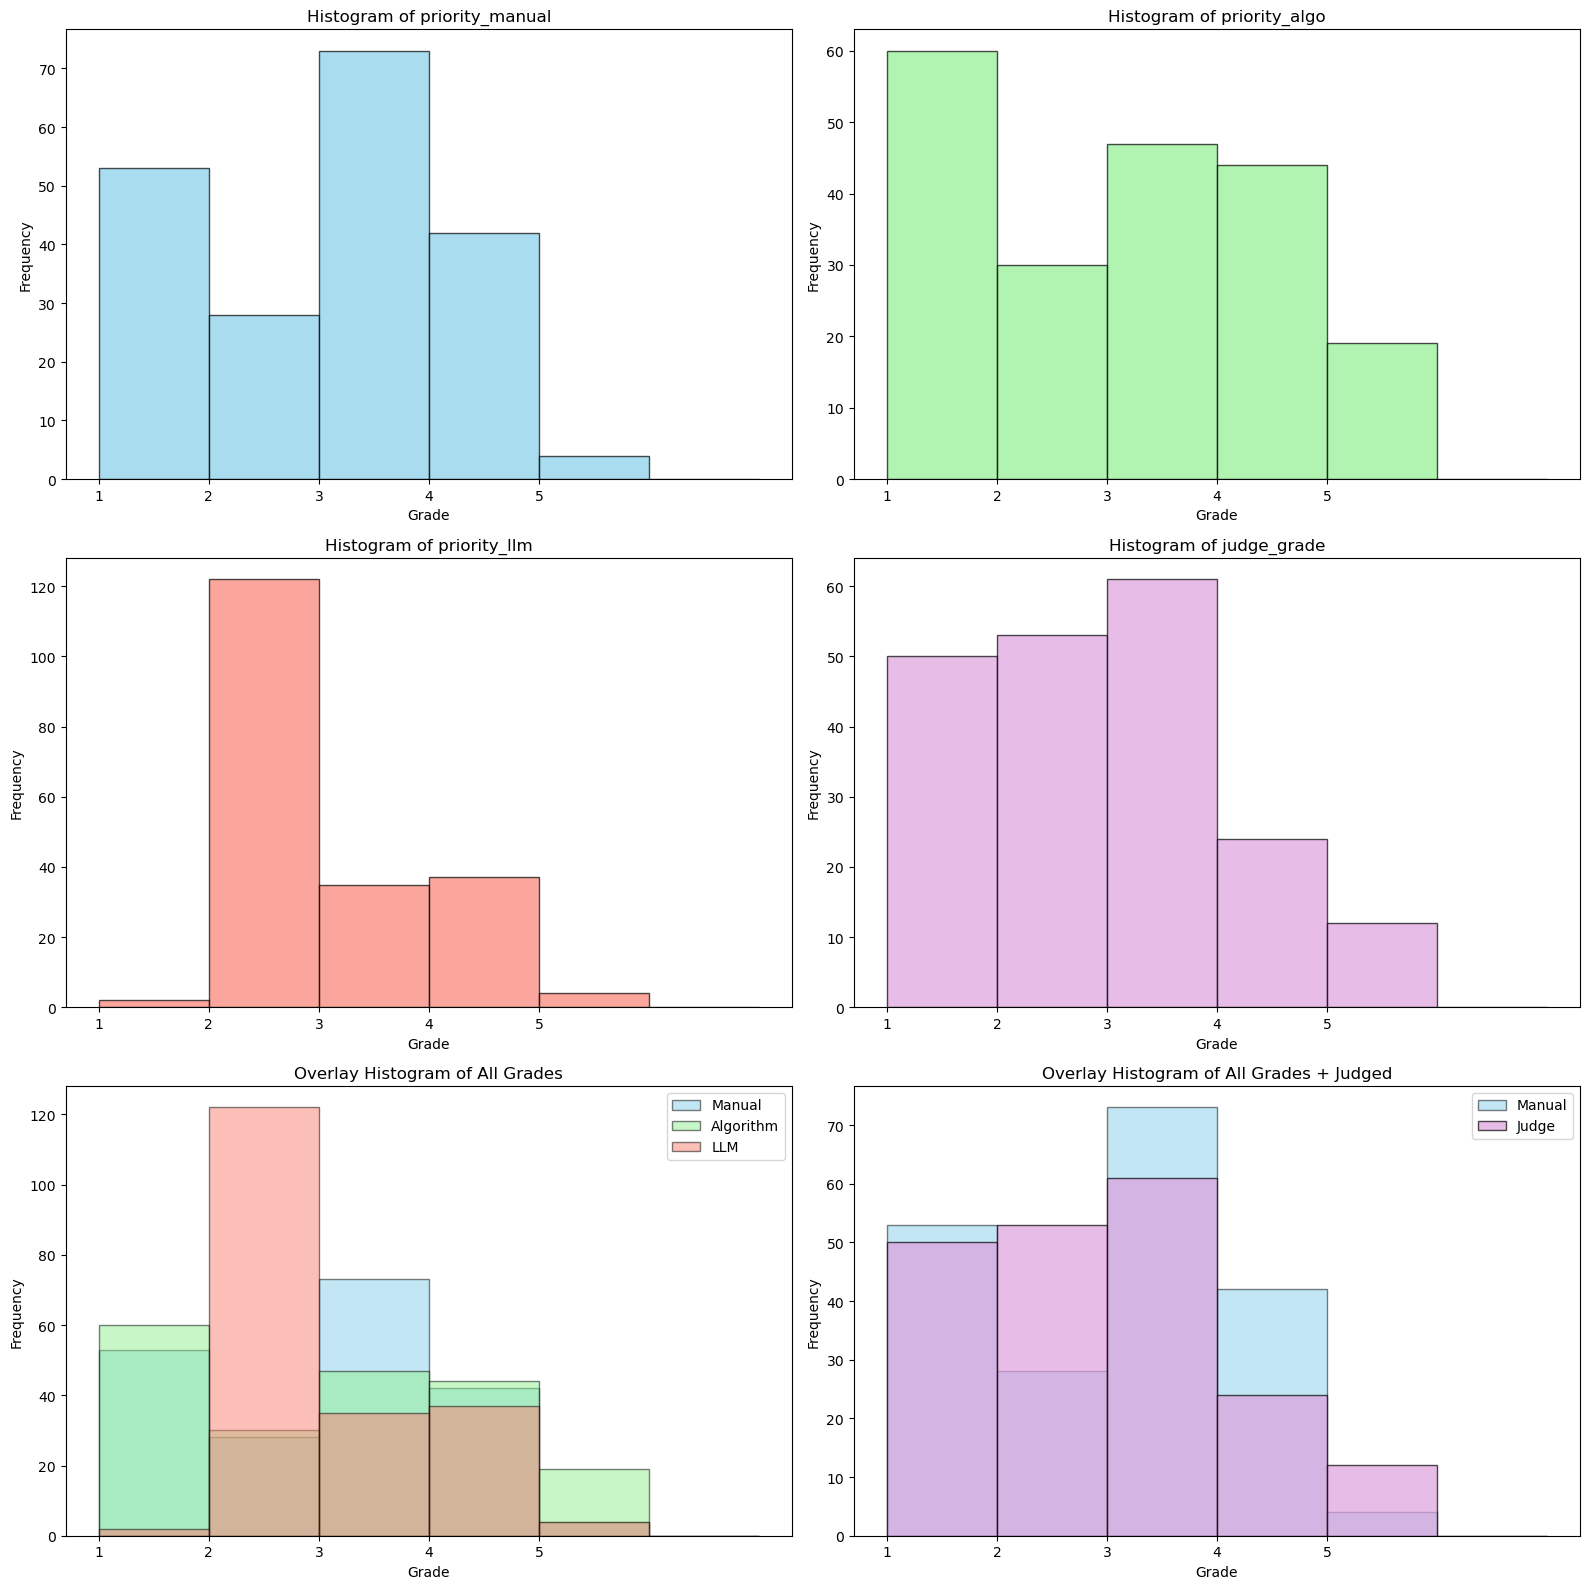

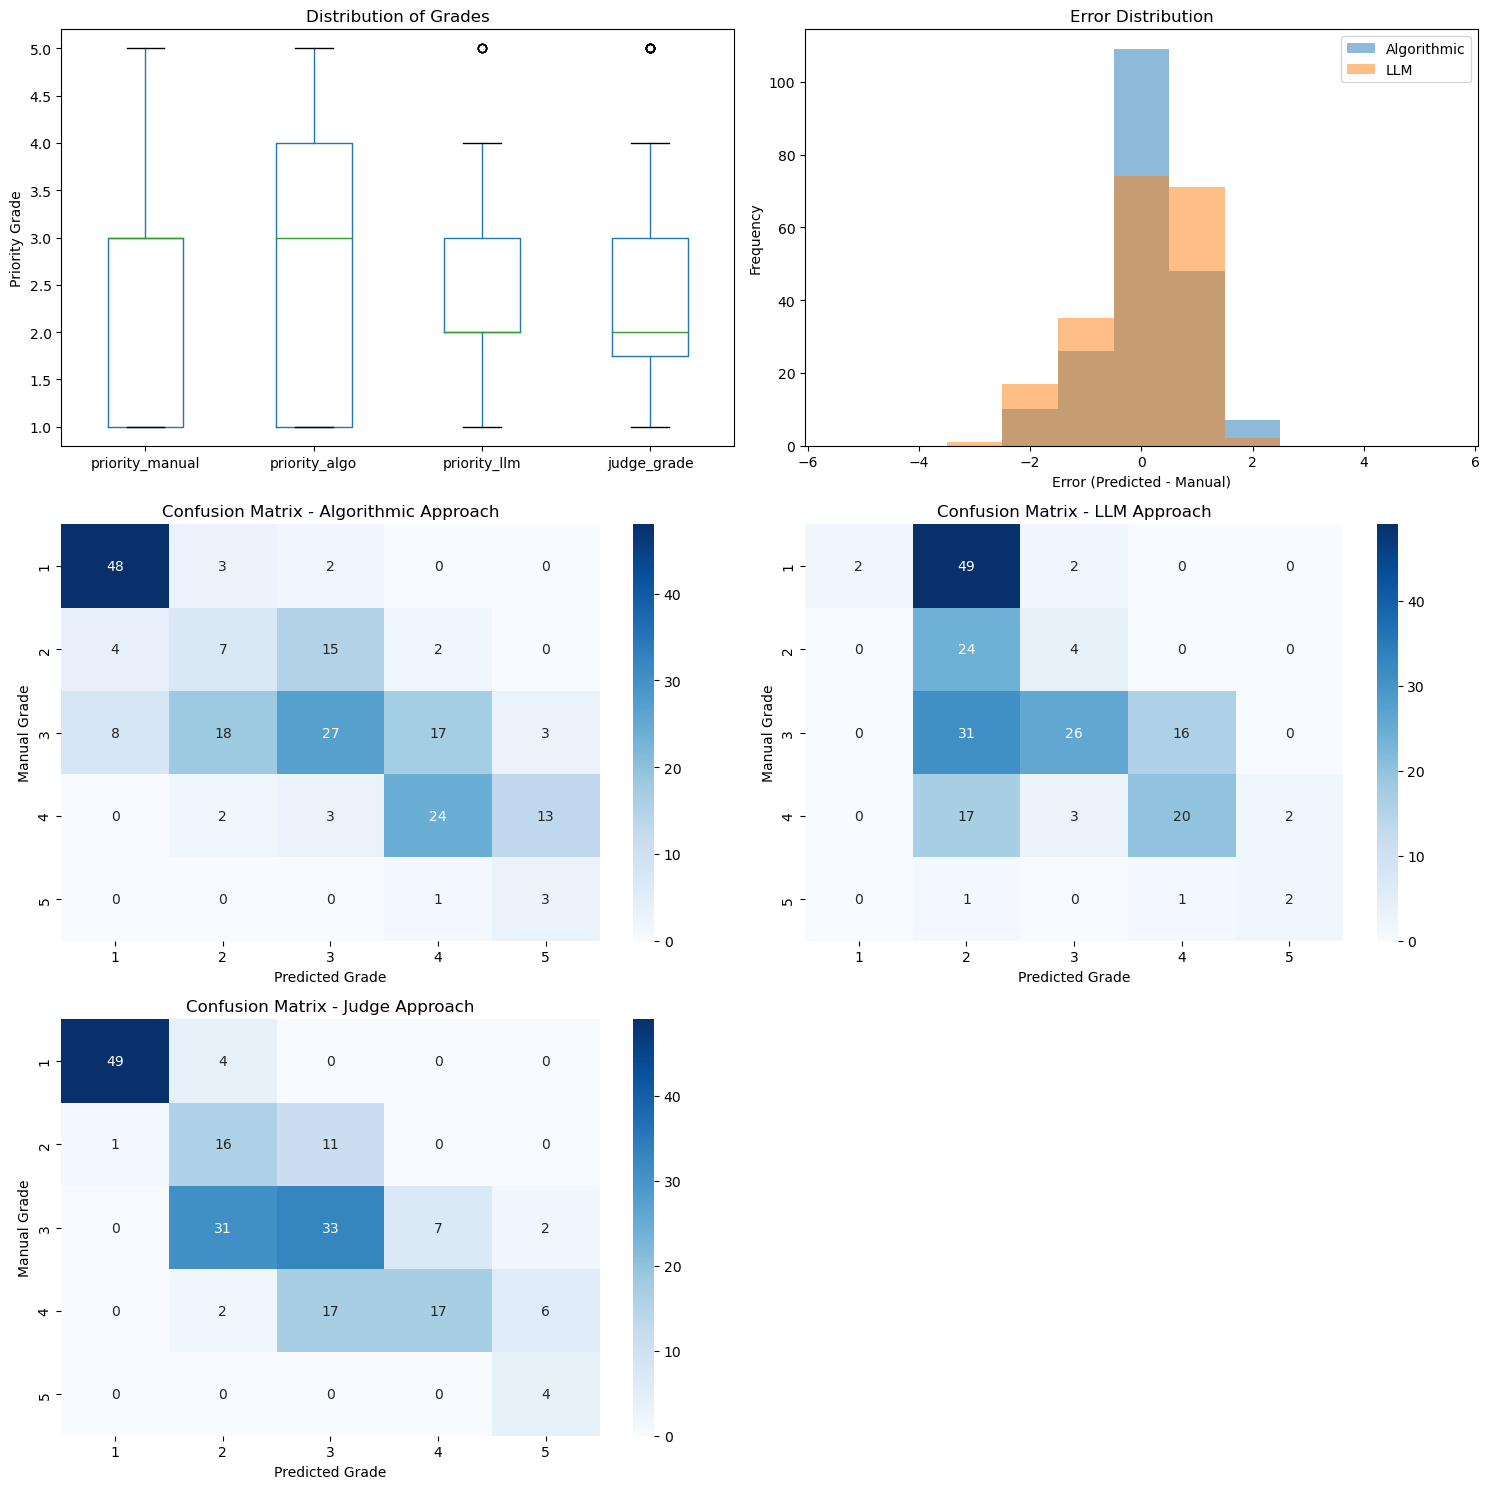

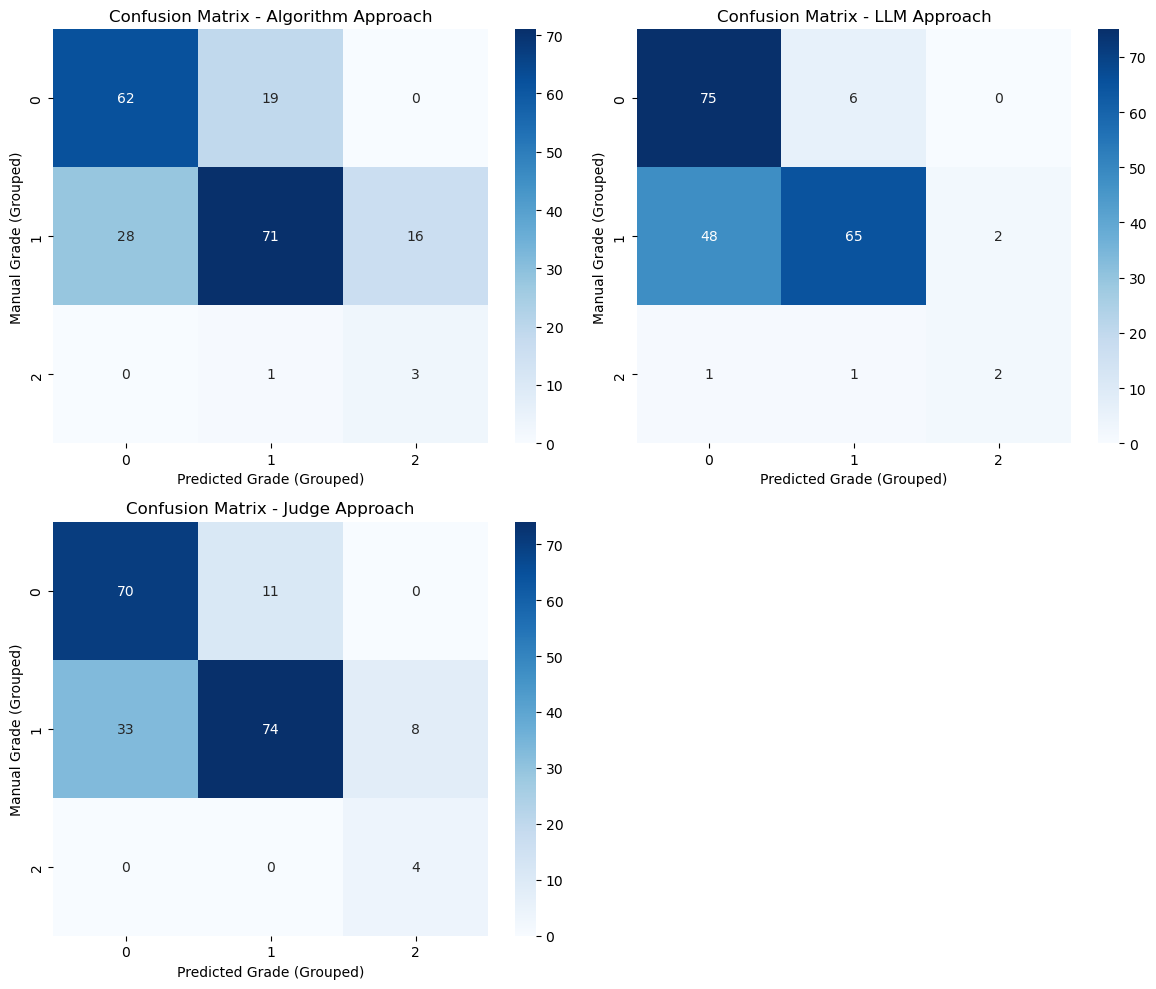

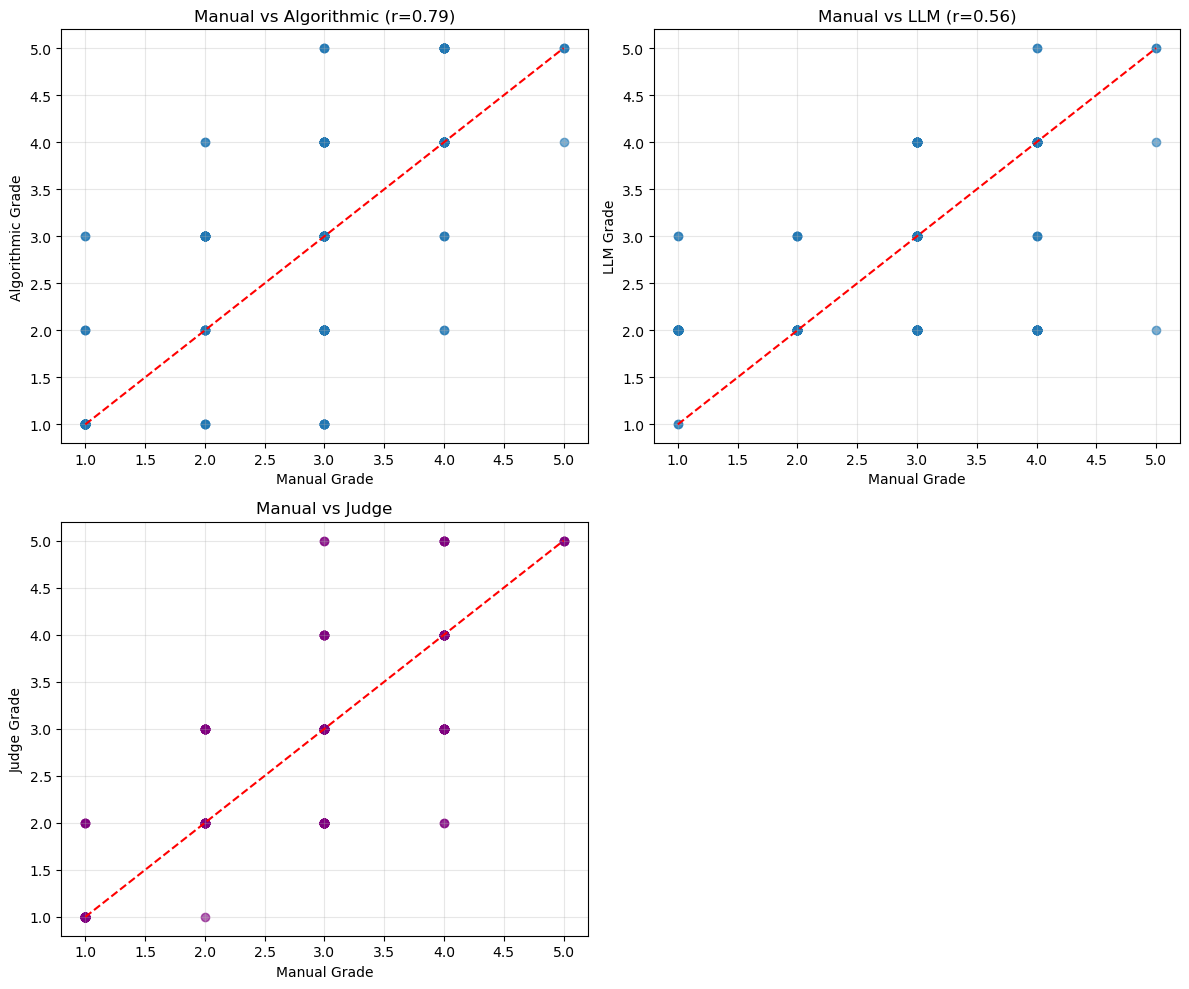

In [10]:
################################
### Visualization of Results ###
################################

# Plot histogram of priority_manual, priority_algo and priority_llm, plus an overlay plot
plt.figure(figsize=(16, 16))

# Histogram for priority_manual
plt.subplot(3, 2, 1)
plt.hist(df_reports_overall['priority_manual'], bins=range(1, 8), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of priority_manual')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))

# Histogram for priority_algo
plt.subplot(3, 2, 2)
plt.hist(df_reports_overall['priority_algo'], bins=range(1, 8), color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Histogram of priority_algo')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))

# Histogram for priority_llm
plt.subplot(3, 2, 3)
plt.hist(df_reports_overall['priority_llm'], bins=range(1, 8), color='salmon', edgecolor='black', alpha=0.7)
plt.title('Histogram of priority_llm')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))

# Histogram for judge_grade
plt.subplot(3, 2, 4)
plt.hist(df_reports_overall['judge_grade'], bins=range(1, 8), color='plum', edgecolor='black', alpha=0.7, label='Judge')
plt.title('Histogram of judge_grade')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))

# Overlay histogram of all three grades
plt.subplot(3, 2, 5)
plt.hist(df_reports_overall['priority_manual'], bins=range(1, 8), color='skyblue', edgecolor='black', alpha=0.5, label='Manual')
plt.hist(df_reports_overall['priority_algo'], bins=range(1, 8), color='lightgreen', edgecolor='black', alpha=0.5, label='Algorithm')
plt.hist(df_reports_overall['priority_llm'], bins=range(1, 8), color='salmon', edgecolor='black', alpha=0.5, label='LLM')
plt.title('Overlay Histogram of All Grades')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.legend()

plt.subplot(3, 2, 6)
plt.hist(df_reports_overall['priority_manual'], bins=range(1, 8), color='skyblue', edgecolor='black', alpha=0.5, label='Manual')
plt.hist(df_reports_overall['judge_grade'], bins=range(1, 8), color='plum', edgecolor='black', alpha=0.7, label='Judge')
plt.title('Overlay Histogram of All Grades + Judged')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.legend()

plt.tight_layout()
plt.show()

# Visualization of results
plt.figure(figsize=(15, 15))

# 1. Distribution of grades
plt.subplot(3, 2, 1)
df_reports_overall[['priority_manual', 'priority_algo', 'priority_llm', 'judge_grade']].boxplot()
plt.title('Distribution of Grades')
plt.ylabel('Priority Grade')
plt.grid(False)

# 2. Confusion matrices
# Helper function to plot confusion matrix
def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=range(1, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Grade')
    ax.set_ylabel('Manual Grade')
    ax.set_xticks(np.arange(5) + 0.5, range(1, 6))
    ax.set_yticks(np.arange(5) + 0.5, range(1, 6))
    ax.set_xticklabels(range(1, 6))
    ax.set_yticklabels(range(1, 6))

plt.subplot(3, 2, 3)
plot_confusion_matrix(plt.gca(), df_reports_overall['priority_manual'], df_reports_overall['priority_algo'], 'Confusion Matrix - Algorithmic Approach')

plt.subplot(3, 2, 4)
plot_confusion_matrix(plt.gca(), df_reports_overall['priority_manual'], df_reports_overall['priority_llm'], 'Confusion Matrix - LLM Approach')

plt.subplot(3, 2, 5)
plot_confusion_matrix(plt.gca(), df_reports_overall['priority_manual'], df_reports_overall['judge_grade'], 'Confusion Matrix - Judge Approach')

# 3. Error distribution
plt.subplot(3, 2, 2)
error_algo = df_reports_overall['priority_algo'] - df_reports_overall['priority_manual']
error_llm = df_reports_overall['priority_llm'] - df_reports_overall['priority_manual']
plt.hist(error_algo, alpha=0.5, bins=np.arange(-5.5, 6.5, 1), label='Algorithmic')
plt.hist(error_llm, alpha=0.5, bins=np.arange(-5.5, 6.5, 1), label='LLM')
plt.xlabel('Error (Predicted - Manual)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

# Confusion matrix for grouped grades
confusion_matrix_algo = confusion_matrix(df_reports_overall['priority_manual_grouped'], df_reports_overall['priority_algo_grouped'])
confusion_matrix_llm = confusion_matrix(df_reports_overall['priority_manual_grouped'], df_reports_overall['priority_llm_grouped'])
confusion_matrix_judge = confusion_matrix(df_reports_overall['priority_manual_grouped'], df_reports_overall['judge_grade_grouped'])

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(confusion_matrix_algo, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Algorithm Approach')
plt.xlabel('Predicted Grade (Grouped)')
plt.ylabel('Manual Grade (Grouped)')

plt.subplot(2, 2, 2)
sns.heatmap(confusion_matrix_llm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LLM Approach')
plt.xlabel('Predicted Grade (Grouped)')
plt.ylabel('Manual Grade (Grouped)')

plt.subplot(2, 2, 3)
sns.heatmap(confusion_matrix_judge, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Judge Approach')
plt.xlabel('Predicted Grade (Grouped)')
plt.ylabel('Manual Grade (Grouped)')

plt.tight_layout()
plt.show()

# Calculate Pearson correlation coefficients
pearson_algo, _ = pearsonr(df_reports_overall['priority_manual'], df_reports_overall['priority_algo'])
pearson_llm, _ = pearsonr(df_reports_overall['priority_manual'], df_reports_overall['priority_llm'])

# Scatter plots to visualize correlation
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(df_reports_overall['priority_manual'], df_reports_overall['priority_algo'], alpha=0.6)
plt.plot([1, 5], [1, 5], 'r--')  # Diagonal line representing perfect prediction
plt.xlabel('Manual Grade')
plt.ylabel('Algorithmic Grade')
plt.title(f'Manual vs Algorithmic (r={pearson_algo:.2f})')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(df_reports_overall['priority_manual'], df_reports_overall['priority_llm'], alpha=0.6)
plt.plot([1, 5], [1, 5], 'r--')  # Diagonal line representing perfect prediction
plt.xlabel('Manual Grade')
plt.ylabel('LLM Grade')
plt.title(f'Manual vs LLM (r={pearson_llm:.2f})')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.scatter(df_reports_overall['priority_manual'], df_reports_overall['judge_grade'], alpha=0.6, color='purple')
plt.plot([1, 5], [1, 5], 'r--')  # Diagonal line representing perfect prediction
plt.xlabel('Manual Grade')
plt.ylabel('Judge Grade')
plt.title('Manual vs Judge')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
####################
### Token Counts ###
####################

# Token counting
import tiktoken

def count_tokens(prompt, model="gpt-3.5-turbo"):
    # Retrieve the encoding for the model. Adjust the model name if needed.
    encoding = tiktoken.encoding_for_model(model)
    tokens = encoding.encode(prompt)
    return len(tokens)

print('The semi-algorithmic approach uses ~1500 tokens')
print('The LLM approach uses ~650 tokens')

The semi-algorithmic approach uses ~1500 tokens
The LLM approach uses ~650 tokens
